# evaluation_5.ipynb

2 main goals
1. look at the embeddings of the ctst model, see if we can find anything meaningful, and label the cells by type
2. Evaluate ISM on my ctst classification model

In [1]:
#we can use evals utils to load in the model
from evals.evals_utils import Evals
ctst_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-23/09-35-11-173861/checkpoints/last.ckpt'

In [2]:
utils = Evals('DNase_ctst',ctst_path, classification=False)

In [4]:
utils.backbone.backbone.embeddings.word_embeddings

Embedding(173, 128)

In [6]:
utils.dataset.tokenizer._vocab_int_to_str

{0: '[CLS]',
 1: '[SEP]',
 2: '[BOS]',
 3: '[MASK]',
 4: '[PAD]',
 5: '[RESERVED]',
 6: '[UNK]',
 7: 'A',
 8: 'C',
 9: 'G',
 10: 'T',
 11: 'N'}

In [8]:
#it's 12 after, let's see how many elements that is, that's elements 12-173
173-12+1 #wait, it's 172 that's the last index cuz idx from 0

162

In [9]:
#now let's look at the embeddings
embeddings = utils.backbone.backbone.embeddings.word_embeddings.weight[12:173]
embeddings.shape

torch.Size([161, 128])

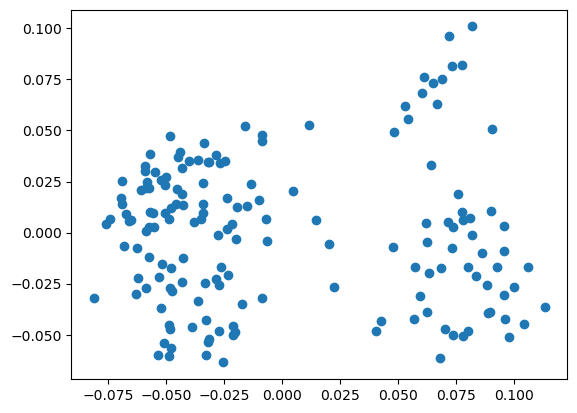

In [25]:
#that looks great! now we can analyze it
#let's do pca and plot it
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embeddings.detach().cpu().numpy())
pca_embeddings = pca.transform(embeddings.detach().cpu().numpy())
plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1])

In [14]:
#let's now find the celltypes
celltypesfile = '/data/leslie/sarthak/data/cCRE_celltype_matrices/cell_types_filtered.txt'
#now load in the celltypes
celltypes = []
with open(celltypesfile) as f:
    for line in f:
        celltypes.append(line.strip())
celltypes

['8988T',
 'chorion_tissue',
 'COLO829',
 'GM03348',
 'AG08395',
 'AG08396',
 'AG20443',
 'germinal_center_tissue',
 'H54',
 'GM10248',
 'GM10266',
 'GM12891',
 'GM12892',
 'GM13976',
 'GM13977',
 'GM18507',
 'GM19238',
 'GM19239',
 'GM19240',
 'GM20000',
 'HEK293T',
 'hepatocyte',
 'HPDE6-E6E7',
 'HTR-8/SVneo',
 'HuH-7',
 'endothelial_cell_of_umbilical_vein_newborn',
 'CWRU1',
 'LNCaP_clone_FGC',
 'MCF-7',
 'D721Med',
 'D341Med',
 'epidermal_melanocyte',
 'C803',
 'osteoblast',
 'RWPE1',
 'SK-N-SH',
 'urothelium_cell_line',
 'A549',
 'AG04449',
 'AG04450',
 'AG09309',
 'AG09319',
 'AG10803',
 'fibroblast_of_the_aortic_adventitia_female',
 'BJ',
 'HS-27A',
 'HS-5',
 'stromal_cell_of_bone_marrow_male',
 'CMK',
 'GM04503',
 'GM04504',
 'GM06990',
 'GM12864',
 'GM12865',
 'GM12878',
 'H1',
 'H7',
 'amniotic_epithelial_cell',
 'brain_pericyte',
 'smooth_muscle_cell_of_the_brain_vasculature_female',
 'cardiac_fibroblast',
 'cardiac_muscle_cell',
 'fibroblast_of_the_conjunctiva',
 'choroid_p

In [27]:
#let's colorcode them
import numpy as np
colors = np.zeros(len(celltypes))
# colors.shape #161,
#if it starts with GM make it 1
for i, celltype in enumerate(celltypes):
    if celltype.startswith('GM'):
        colors[i] = 1
    elif celltype.startswith('AG'):
        colors[i] = 2
    elif 'fibroblast' in celltype:
        colors[i] = 3

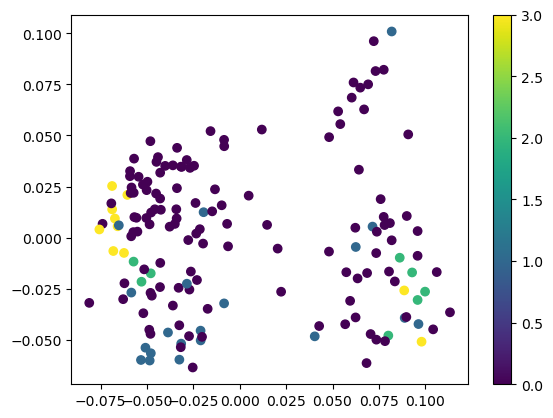

In [22]:
#now do the same scatter plot with these colors and label the colors
plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=colors, cmap='viridis')

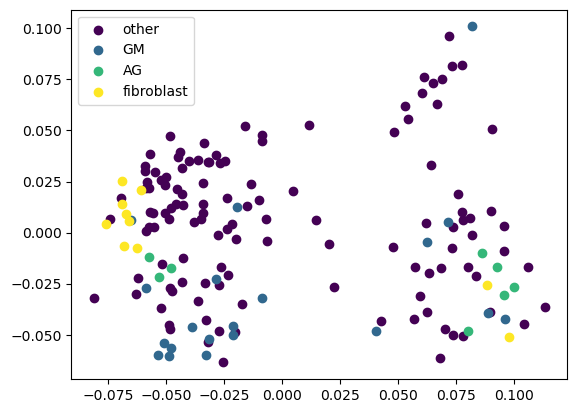

In [29]:
import matplotlib.pyplot as plt
import numpy as np

unique_colors = np.unique(colors)

# Set the colormap
cmap = plt.get_cmap('viridis')

# Calculate the number of categories for normalization
norm = plt.Normalize(vmin=min(unique_colors), vmax=max(unique_colors))

# Scatter plot for each category
category_list = ['other', 'GM', 'AG', 'fibroblast']
for i,color in enumerate(unique_colors):
    indices = np.where(colors == color)
    plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], color=cmap(norm(color)), label=category_list[i])

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=unique_colors, label='Categories')

# Add a legend
plt.legend()

plt.show()

#gotta find better ways of labelling this
#also AG and GM can literally be completely different cell types, just means same cell line I think?? I don't know, have to look into this


# redo the plots

In [1]:
#now let's load in the predictions and the targets for classification
import torch
treg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_targets_reg.pt') #the target regression
tclass = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_targets_class.pt') #target classes
preg1 = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_predicts.pt') #the predictions from original model
preg2 = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_predicts_reg.pt') #predictions from model that also does class
pclass = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_predicts_class.pt') #prediction from model that also does class
#and print all the shapes
print(treg.shape, tclass.shape, preg1.shape, preg2.shape, pclass.shape)

torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])


In [2]:
#now we have to consider masking them
mask = treg != -10
preg1_masked = preg1[mask]
preg2_masked = preg2[mask]
treg_masked = treg[mask]
#and print shapes
print(preg1_masked.shape, preg2_masked.shape, treg_masked.shape)

torch.Size([16352624]) torch.Size([16352624]) torch.Size([16352624])


In [5]:
import numpy as np
treg_masked = treg.clone()
preg1_masked = preg1.clone()
preg2_masked = preg2.clone()
#now find values that are -10 in the target
mask = treg == -10
#and replace the mask indices with NaN
treg_masked[mask] = np.nan
preg1_masked[mask] = np.nan
preg2_masked[mask] = np.nan
#print all the shapes
print(treg_masked.shape, preg1_masked.shape, preg2_masked.shape)

torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])


In [11]:
#now let's do it per column
from scipy.stats import pearsonr
corrs1 = []
corrs2 = []
for i in range(treg_masked.shape[1]):
    #a key is we need to remove the NaN values
    temp_target = treg_masked[:,i]
    #and remove nan
    temp_target = temp_target[~torch.isnan(temp_target)]
    # print(temp_target, temp_target.shape)
    
    # break
    temp_reg1 = preg1_masked[:,i]
    temp_reg1 = temp_reg1[~torch.isnan(temp_reg1)]
    corr = pearsonr(temp_target, temp_reg1)
    corrs1.append(corr)
    temp_reg2 = preg2_masked[:,i]
    temp_reg2 = temp_reg2[~torch.isnan(temp_reg2)]
    corr = pearsonr(temp_target, temp_reg2)
    corrs2.append(corr)
#print the means
print(np.mean(corrs1), np.mean(corrs2)) #only slighlty higher

0.3334134577661768 0.3456259685463429


Text(0.5, 1.0, 'correlation for each cell type')

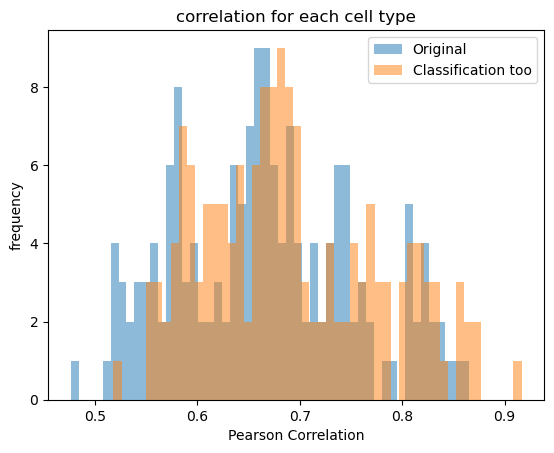

In [12]:
#plot the distribution
import matplotlib.pyplot as plt
plt.hist(np.array(corrs1)[:,0], bins = 50, alpha = 0.5)
plt.hist(np.array(corrs2)[:,0], bins = 50, alpha=0.5)
#legend
plt.legend(['Original', 'Classification too'])
plt.xlabel('Pearson Correlation')
plt.ylabel('frequency')
plt.title('correlation for each cell type')

In [9]:
#and now per row
from tqdm import tqdm
corrs1 = []
corrs2 = []
for i in tqdm(range(treg_masked.shape[0])):
    #a key is we need to remove the NaN values
    temp_target = treg_masked[i,:]
    #and remove nan
    temp_target = temp_target[~torch.isnan(temp_target)]
    temp_reg1 = preg1_masked[i,:]
    temp_reg1 = temp_reg1[~torch.isnan(temp_reg1)]
    corr = pearsonr(temp_target, temp_reg1)
    corrs1.append(corr)

    temp_reg2 = preg2_masked[i,:]
    temp_reg2 = temp_reg2[~torch.isnan(temp_reg2)]
    corr = pearsonr(temp_target, temp_reg2)
    corrs2.append(corr)

  0%|          | 0/105252 [00:00<?, ?it/s]

100%|██████████| 105252/105252 [04:01<00:00, 435.30it/s]


0.21928802238523684 0.2596769178317544


Text(0.5, 1.0, 'correlations for each CRE')

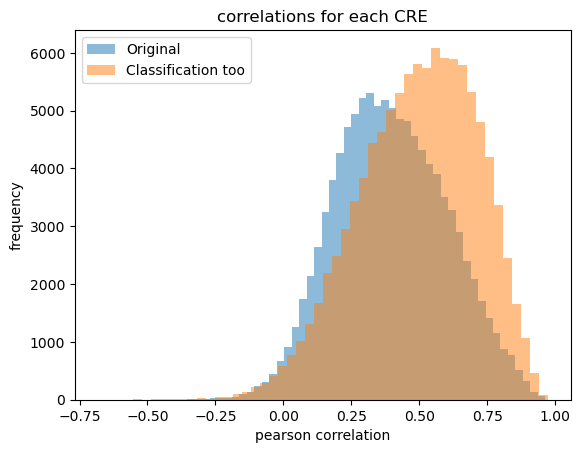

In [10]:
print(np.mean(corrs1), np.mean(corrs2)) #only slighlty higher
#and plot
plt.hist(np.array(corrs1)[:,0], bins = 50, alpha = 0.5)
plt.hist(np.array(corrs2)[:,0], bins = 50, alpha = 0.5)
#legend
plt.legend(['Original', 'Classification too'])
plt.xlabel('pearson correlation')
plt.ylabel('frequency')
plt.title('correlations for each CRE')

# testing to see if my evaluation is correct